# Image data augmentation

In [ ]:
% cd drive/MyDrive/data/aug_data

In [ ]:
! pip install wand
! pip install straug
! apt-get install libmagickwand-dev

In [336]:
import cv2
import skimage
import numpy as np
import wand
from PIL import Image
import matplotlib.pyplot as plt
from collections import namedtuple
from skimage import transform
from straug.weather import Fog, Snow, Frost, Rain, Shadow
from straug.noise import ShotNoise, ImpulseNoise, SpeckleNoise
from straug.warp import Curve, Distort

from skimage.io import imsave
from skimage import data


%matplotlib inline

In [ ]:
def save_image(img: np.array, path: str):
    result = Image.fromarray(img.astype(np.uint8))
    result.save(path)

## Affine Transformation (rotation, scale, translation, shearing)

Самописный метод для аффиного преобразования не работает с текстовыми изображениями, по всей видимости из-за интерполяции. Оставлю на память о проделанной работе, но буду использовать реализовнный из skimage.

In [ ]:
def affine_transform(img: np.array, mat: np.array):
    # T(x) = A(x − c) + t + c
    
    H, W, _ = img.shape
    cx, cy = (H + 1) // 2 - 1, (W + 1) // 2 - 1

    offset_M = make_translation([cx, cy]) @ mat
    transformed_img = np.zeros_like(img)

    transformed_idx = []

    for x in range(H):
        for y in range(W):
            warp_coords = offset_M @ np.array([x - cx, y - cy, 1])
            transformed_idx.append(warp_coords[:2])

    transformed_idx = np.array(transformed_idx)
    transformed_img = cv2.remap(
        img, 
        transformed_idx[:, 0].astype('float32').reshape(W, H), 
        transformed_idx[:, 1].astype('float32').reshape(W, H), 
        cv2.INTER_CUBIC
    )
    
    return transformed_img.transpose(1, 0, 2)

In [ ]:
def make_reflection():
    mat = np.array([
      [-1, 0, 0],
      [0,  1, 0],
      [0,  0, 1],
    ])

    return mat

def make_rotation(params):
    angle = params[0]
    mat = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
    ])

    return mat

def make_scaling(params):
    tx, ty = params[0], params[1]
    mat = np.array([
      [tx, 0,  0],
      [0,  ty, 0],
      [0,  0,  1],
    ])

    return mat

def make_translation(params):
    tx, ty = params[0], params[1]
    mat = np.array([
      [1,  0, tx],
      [0,  1, ty],
      [0,  0, 1],
    ])

    return mat

def make_shearing(params):
    tx, ty = params[0], params[1]
    mat = np.array([
      [1,  tx, 0],
      [ty, 1,  0],
      [0,  0,  1],
    ])

    return mat

In [ ]:
def affine_transform(img: np.array, angle=0, scale=0, mat=None):
    H, W, _ = img.shape
    cx, cy = (H + 1) // 2 - 1, (W + 1) // 2 - 1

    mat_ = cv2.getRotationMatrix2D((cx, cy), angle, scale)
    if mat is not None:
        mat_ = (mat @ np.vstack((mat_, np.array([[0, 0, 1]]))))[:2, :]
    
    out_img = cv2.warpAffine(img, mat_, (W, H))
    return out_img

In [ ]:
img = np.asarray(Image.open('../10.png')).astype('uint8')
affine_img = affine_transform(img, scale=0.8, angle=35)

In [412]:
img = np.asarray(Image.open('../9.png')).astype('uint8')
affine_img = affine_transform(img, scale=0.8, angle=25)
affine_img = Snow()(Image.fromarray(affine_img), mag=2, prob=0.9)

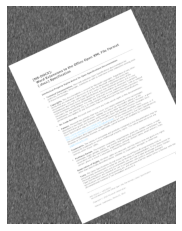

In [413]:
plt.imshow(affine_img)
plt.axis('off')
plt.show()

In [414]:
save_image(np.array(affine_img), '9_7.png')

## Projective transformation

In [ ]:
def projective_transform(img: np.array, mat: np.array):
    tform = transform.ProjectiveTransform(matrix=mat)
    return transform.warp(img, tform)

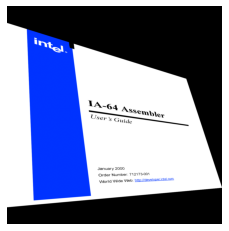

In [472]:
img = np.asarray(Image.open('4_9.png')).astype('uint8')
h, w, _ = img.shape

input = np.float32([[0,100], [w/1.2,h/3], [w,h/1.2], [0,h-100]])
output = np.float32([[0,0], [w-1,0], [w-1,h-1], [0,h-1]])
matrix = cv2.getPerspectiveTransform(input, output)

tf_img = projective_transform(img, matrix)

plt.imshow(tf_img)
plt.axis('off')
plt.show()

In [473]:
imsave('4_9.png', tf_img)

## Distortion

In [462]:
def barrel(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.background_color = wand.color.Color('black')
        args = (
            -0.2,  # A
            0.2,   # B
            0.4,  # C
            0.9,  # D
        )
        img.distort('barrel', args)
        img.save(filename=out_path)

In [463]:
barrel('10_9.png', '10_9.png')

In [ ]:
def polinomial(in_path, out_path):
    Point = namedtuple('Point', ['x', 'y', 'i', 'j'])

    with wand.image.Image(filename=in_path) as img:
        img.background_color = wand.color.Color('black')
        img.virtual_pixel = 'background'
        order = 1.5
        alpha = Point(0, 0, 0, 0)
        beta = Point(100, 200, 200, 100)
        gamma = Point(400, 400, 400, 400)
        delta = Point(0, 0, 0, 0)
        args = (
            order,
            alpha.x, alpha.y, alpha.i, alpha.j,
            beta.x, beta.y, beta.i, beta.j,
            gamma.x, gamma.y, gamma.i, gamma.j,
            delta.x, delta.y, delta.i, delta.j,
        )
        img.distort('polynomial', args)
        img.save(filename=out_path)

In [457]:
polinomial('1_9.png', '1_9.png')

In [350]:
def curve(in_path):
    img = Image.open(in_path)
    curve_img = Curve()(img, mag=3, prob=0.8)
    return curve_img

def distort(in_path):
    img = Image.open(in_path)
    distort_img = Distort()(img, mag=2, prob=0.6)
    return distort_img

In [351]:
img = curve('../10.png')
img = ShotNoise()(img, mag=2, prob=0.6)
save_image(np.array(img), '10_6.png')

## Saltpepper Noise, Gaussian noise

In [ ]:
def saltpepper_noise(image: np.array, proportion: float=0.2):
    image_copy = image.copy()
    h, w, c = image.shape
    n_points = int(proportion * h * w)
    
    xs = np.random.randint(
        low=0,
        high=h,
        size=(n_points, ),
    )
    
    ys = np.random.randint(
        low=0,
        high=w,
        size=(n_points, ),
    )

    image_copy[xs, ys, :] = np.random.choice(
        a=[0, 255],
        size=(n_points, c),
        p=[0.5, 0.5],
    )
    
    return image_copy

def gaussian_noise(image: np.array, mean: float=0.2, sigma: float=0.4):
    noise_image = image / 255. + np.random.normal(mean, sigma, image.shape)
    noise_image = (np.clip(noise_image, 0, 1) * 255).astype(np.uint8)
    
    return noise_image

In [475]:
img = np.asarray(Image.open('10_9.png')).astype('uint8')
gaussian_img = gaussian_noise(img, 0.4, 0.2)

In [476]:
save_image(gaussian_img, '10_9.png')

## ShotNoise, Impulse noise

In [451]:
def shot(in_path):
    img = Image.open(in_path)
    shot_img = ShotNoise()(img, mag=3, prob=0.8)
    return shot_img

def impulse(in_path):
    img = Image.open(in_path)
    impulse_img = ImpulseNoise()(img, mag=2, prob=0.9)
    return impulse_img

def speckle(in_path):
    img = Image.open(in_path)
    speckle_img = SpeckleNoise()(img, mag=3, prob=0.7)
    return speckle_img

In [452]:
img = shot('../7.png')
save_image(np.array(img), '7_9.png')

## Blur

In [445]:
def rotational_blur(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.rotational_blur(angle=2)
        img.save(filename=out_path)

def adaptive_blur(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.adaptive_blur(radius=15, sigma=10)
        img.save(filename=out_path)

def motion_blur(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.motion_blur(radius=15, sigma=8, angle=45)
        img.save(filename=out_path)

def gaussian_blur(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.gaussian_blur(sigma=1.8)
        img.save(filename=out_path)

In [477]:
motion_blur('6_9.png', '6_9.png')

## Special

In [454]:
def wave(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.wave(amplitude=img.height / 200, wave_length=img.width / 1.5)
        img.save(filename=out_path)

def swirl(in_path, out_path):
    with wand.image.Image(filename=in_path) as img:
        img.swirl(degree=5)
        img.save(filename=out_path)

def snow(in_path):
    img = Image.open(in_path)
    snow_img = Snow()(img, mag=3, prob=0.8)
    return snow_img

def frost(in_path):
    img = Image.open(in_path)
    frost_img = Frost()(img, mag=3, prob=0.7)
    return frost_img

In [456]:
sn_img = frost('../10.png')
save_image(np.array(sn_img), '10_9.png')